# VOYAGER DATA

This script has two purposes:

1. **Reproduce a particularly messy structure function in FraternaleEA (2019)**, including his statistical threshold. *I have pretty much reproduced the structure functions from the inner heliosheath (V1, 2011), though at a reduced frequency due to computation time.*
2. **Apply my correction factor to an interval from Voyager.** A LISM interval would be coolest, but that paper does not have SFs of that region to compare with, only spectra (for which they use their suite of spectral estimation techniques). That said, I will also be converting the SF to an E.S. In either case, there may be issues around interval length (so as to remain consistent with my standardised intervals) that make direct comparisons difficult. (See comments in markdown section "Issues with comparing results".) *I have so far done this for both (need to reproduce both, but need to finish 3D smoothing)* 

In [88]:
import numpy as np
import pandas as pd
import math as m
import pickle
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates

import src.utils as utils
import src.params as params
import src.sf_funcs as sf

# Set matplotlib font size
plt.rc("text", usetex=True)
plt.rc("font", family="serif", serif="Computer Modern", size=10)

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [89]:
def SmoothySpec(a, nums=None):
    """Smooth a curve using a moving average smoothing"""
    b = a.copy()
    if nums is None:
        nums = 2 * len(b) // 3
    for i in range(nums):
        b[i + 1 : -1] = 0.25 * b[i:-2] + 0.5 * b[i + 1 : -1] + 0.25 * b[i + 2 :]
    return b

# Fraternale et al. (2019)

In [90]:
from sunpy.timeseries import TimeSeries

spacecraft = "voyager"
cadence = "48s"

data = TimeSeries(
    "data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf",
    concatenate=True,  # Not strictly relevant here as only reading one file at a time
)
# data.columns
# data.units
# data.time_range

df_raw = data.to_dataframe()

df_raw = df_raw.loc[:, params.mag_vars_dict[spacecraft]]

# Rename the first three columns to Bx, By, Bz
# df_raw = df_raw.rename(
#     columns={
#         params.mag_vars_dict[spacecraft][0]: "Bx",
#         params.mag_vars_dict[spacecraft][1]: "By",
#         params.mag_vars_dict[spacecraft][2]: "Bz",
#     }
# )

In [91]:
df = df_raw.resample(cadence).mean()

<Axes: >

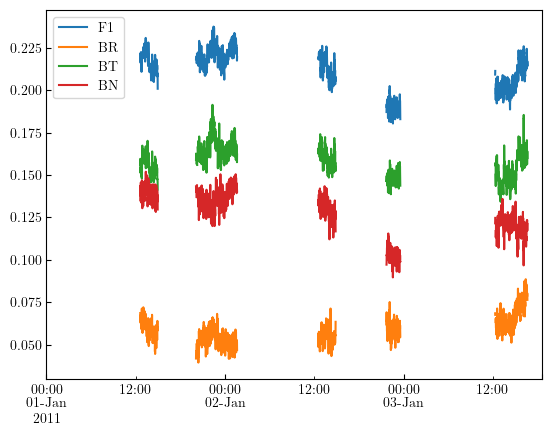

In [92]:
df[:5000].plot()

Getting two derived vars

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

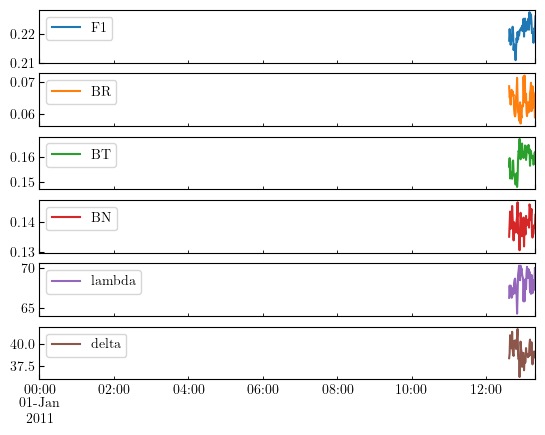

In [93]:
def convert_angle(x):
    if x < 0:
        x += 360
    return x


df["lambda"] = (
    df["BT"].div(df["BR"]).apply(m.atan).apply(m.degrees).apply(convert_angle)
)
df["delta"] = df["BN"].div(df["F1"]).apply(m.asin).apply(m.degrees)

df[:1000].plot(subplots=True)

In [94]:
# Proportion of missing data
print(df.isna().sum() / len(df["F1"]))

F1        0.695021
BR        0.695021
BT        0.695021
BN        0.695021
lambda    0.695021
delta     0.695021
dtype: float64


### Re-creating Fig. 1(a)

In [95]:
# Resample to daily cadence
df_daily = df.resample("D").mean()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

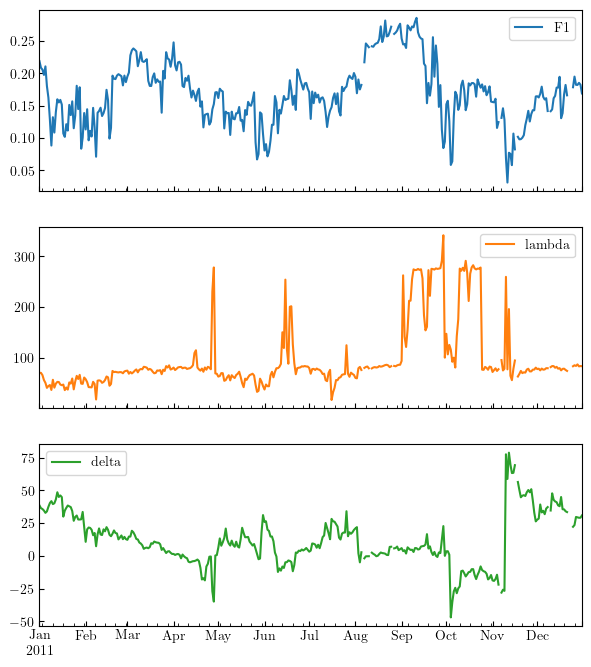

In [96]:
df_daily[["F1", "lambda", "delta"]].plot(subplots=True, figsize=(7, 8))

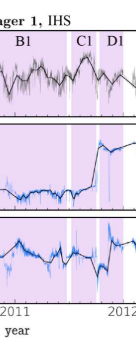

Looks fine, apart from lambda.

Proceeding to extract interval D1 (we won't be using lambda)

In [97]:
# Get DOY 276-365 from the raw data
# subset = df["2021-02-01":"2021-05-01"]
subset = df["2011-10-03":"2011-12-31"]

In [98]:
del df
del df_daily
print(len(subset))

160587


In [99]:
subset.isna().sum() / len(subset)

F1        0.798315
BR        0.798315
BT        0.798315
BN        0.798315
lambda    0.798315
delta     0.798315
dtype: float64

80% data missing

### Computing full SFs

In [100]:
subset_resampled = subset.resample("10min").mean()  # Now only 12,000 long
len(subset_resampled)

12847

In [101]:
# Takes about 20-30 seconds,

sf_full = utils.calc_struct_sdk(
    data=subset_resampled["BT"],
    freq=1 / 600,
    orders=[1, 2, 3, 4],
    max_lag_fraction=0.5,
    plot=False,
)

In [102]:
subset_lint = subset_resampled.interpolate(method="linear")

sf_full_lint = utils.calc_struct_sdk(
    data=subset_lint["BT"],
    freq=1 / 600,
    orders=[1, 2, 3, 4],
    max_lag_fraction=0.5,
    plot=False,
)

### Thresholding procedure
"the computation of $S$ is nontrivial for Voyager data sets due to the amount and distribution of missing data." They do not interpolate, but they do account for the variable reduction in sample size at each lag by applying a threshold of statistical significance as to whether they use certain lags to calculate the slopes

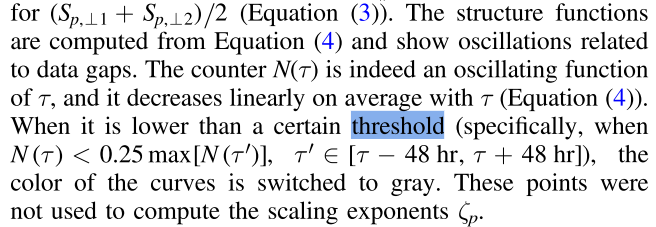

In [103]:
# Define the window size for 48 hours in seconds
# Convert index to time index
sf_full.index = pd.to_timedelta(sf_full.index, unit="s")

window_size = pd.to_timedelta("48h")

# Compute the rolling maximum for a 48-hour window
sf_full["rolling_max"] = (
    sf_full["N"].rolling(window=window_size, min_periods=1, center=True).max()
)

# Compute the threshold
sf_full["threshold"] = 0.25 * sf_full["rolling_max"]

# Determine the color based on the threshold
sf_full["color"] = np.where(sf_full["N"] < sf_full["threshold"], "gray", "black")

# Convert the time index to back to seconds
sf_full.index = sf_full.index.total_seconds()

### Computing correlation scale

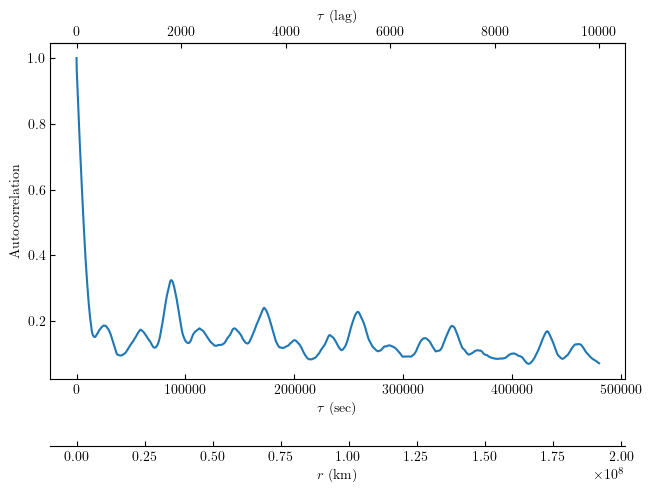

Correlation time = 8694.0s = 2.0 hours


In [104]:
time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [subset.BR, subset.BT, subset.BN],
    nlags=10000,  # Arbritrary large number
    plot=True,
)
tc_exp = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

print(f"Correlation time = {np.round(tc_exp)}s = {np.round(tc_exp/3600)} hours")

Calculating correlation time, using full 60-day dataset. Note highly wiggly ACF due to gaps. 

Also calculating $\lambda_C$ using integral method

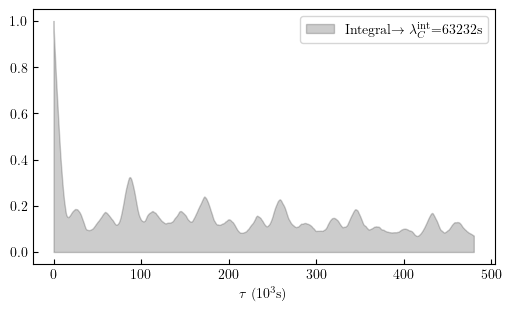

17.5644176343441
hours


In [105]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
tc, fig, ax = utils.compute_outer_scale_integral(time_lags_lr, r_vec_lr, fig, ax, True)
# print(f"Correlation time = {np.round(tc)}s = {np.round(tc/3600)} hours")

plt.show()
print(tc / 60 / 60)
print("hours")

In [106]:
print(
    "10 of these is ",
    np.round(10 * tc / 60 / 60 / 24, 2),
    "days, compared with full data length of",
    subset.index[-1] - subset.index[0],
)

10 of these is  7.32 days, compared with full data length of 89 days 05:08:48


Note that this integral version is much longer, which will make the final interval lengths *slightly* more comparable with Fraternale's ints. (But note in either case the underlying ACF does look a bit silly)

## Apples with oranges: Frat's SFs

Text(2011-10-11 01:12:30.938320026, 0.12, '$10\\lambda_C=10\\times17.56$ hours')

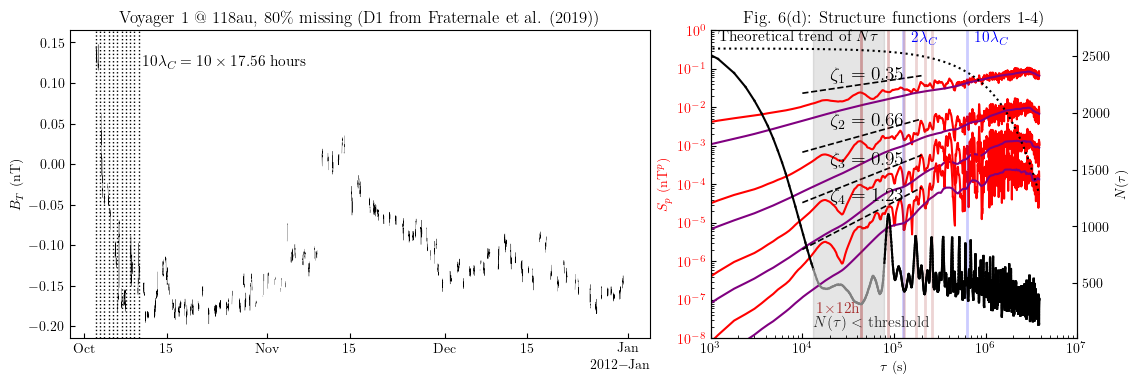

In [110]:
# Plot structure functions
xlim = (1e3, 1e7)
ylim_sf = (1e-8, 1e0)
ylim_kurt = (2, 10)

# sdk = sf[[2, 4]].copy()
# sdk["kurtosis"] = sdk[4].div(sdk[2] ** 2)


fig = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 5, wspace=0.4)
ax0 = plt.subplot(gs[0, 0:3])

ax1 = plt.subplot(gs[0, 3:])

ax0.plot(subset_resampled.BT, c="black", lw=0.2)
for i in range(11):
    ax0.axvline(
        subset_resampled.index[0] + pd.Timedelta(tc * i, "s"),
        color="black",
        linestyle="dotted",
        lw=1,
    )
ax0.set_title(r"Voyager 1 @ 118au, 80\% missing (D1 from Fraternale et al. (2019))")
ax0.set_ylabel("$B_T$ (nT)")
ax0.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax0.xaxis.get_major_locator())
)

for p in [1, 2, 3, 4]:
    ax1.plot(sf_full.index, sf_full[p], c="red", label=f"p={p} (naive)")
    qi, xi, pi = utils.fitpowerlaw(sf_full.index, sf_full[p].values, 1e4, 2e5)
    ax1.plot(
        xi,
        pi * 2,
        c="black",
        ls="--",
        lw=1.2,
        label="Inertial range power-law fit: $\\alpha_i$ = {0:.2f}".format(qi[0]),
    )

    # Add the slope value as an annotation based on location of the fit
    plt.annotate(
        "$\\zeta_{0} = {1:.2f}$".format(p, qi[0]),
        (xi[0] * 2, np.median(pi) * 2),
        fontsize=14,
    )

    ax1.plot(sf_full_lint.index, sf_full_lint[p], c="purple", label=f"p={p} (LINT)")

# ax1.plot(sf_std.index, sf_std[2], c="blue", label="10 lambda C")


ax1.semilogx()
ax1.semilogy()
ax1.set(title="Fig. 6(d): Structure functions (orders 1-4)", xlabel="Lag (s)")
if xlim is not None:
    ax1.set_xlim(xlim)
if ylim_sf is not None:
    ax1.set_ylim(ylim_sf)

# plt.show()

ax1.set_xlabel("$\\tau$ (s)")
ax1.set_ylabel("$S_p$ (nT$^p$)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

rectangle_x = sf_full[sf_full.color == "gray"].index[0]
rectangle_width = (
    sf_full[sf_full.color == "gray"].index[-1]
    - sf_full[sf_full.color == "gray"].index[0]
)

# Add rectangle to show the range of the power-law fit
ax1.add_patch(
    plt.Rectangle(
        (rectangle_x, 1e-8),
        rectangle_width,
        1,
        color="black",
        alpha=0.1,
    ),
)

ax2 = ax1.twinx()
plt.plot(
    sf_full.index,
    0.2 * (len(subset_resampled) - (sf_full.index / 600)),
    color="black",
    ls="dotted",
    label="Theoretical sample size",
)
for i in range(len(sf_full) - 1):
    ax2.plot(
        sf_full.index[i : i + 2],
        sf_full["N"].values[i : i + 2],
        color=sf_full["color"].values[i],
    )
ax2.set_ylabel("$N(\\tau)$", color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax1.text(rectangle_x, 2e-8, "$N(\\tau)<$ threshold", fontsize=11, alpha=0.8)
ax1.text(1.2e3, 5e-1, "Theoretical trend of $N\\tau$", fontsize=11)
# Add vertical line at lag equal to 8 correlation times
ax1.axvline(x=10 * tc, c="blue", lw=2, alpha=0.2)
ax1.axvline(x=2 * tc, c="blue", lw=2, alpha=0.2)
# ax1.axvline(x=48 * 3600, c="purple", lw=2, alpha=0.2)
ax1.axvline(x=12 * 3600, c="brown", lw=2, alpha=0.4)
ax1.axvline(x=24 * 3600, c="brown", lw=2, alpha=0.3)
ax1.axvline(x=36 * 3600, c="brown", lw=2, alpha=0.2)
ax1.axvline(x=48 * 3600, c="brown", lw=2, alpha=0.2)
ax1.axvline(x=60 * 3600, c="brown", lw=2, alpha=0.2)
ax1.axvline(x=72 * 3600, c="brown", lw=2, alpha=0.2)

ax1.text(10 * tc * 1.2, 5e-1, "$10\\lambda_C$", fontsize=11, c="blue")
ax1.text(2 * tc * 1.2, 5e-1, "$2\\lambda_C$", fontsize=11, c="blue")

# ax1.text(48 * 3600 * 1.2, 5e-1, "Burger max lag", fontsize=11, c="purple")
ax1.text(12 * 3600 / 3, 5e-8, "1$\\times$12h", fontsize=11, c="brown")

# Annotate first panel with the correlation time
ax0.text(
    subset_resampled.index[0] + pd.Timedelta(11 * tc, "s"),
    0.12,
    f"$10\\lambda_C=10\\times{np.round(tc / 60 / 60, 2)}$ hours",
    fontsize=11,
    c="black",
)
# plt.savefig("plots/background/voyager_sf.png")

Compare with Fraternale below (noting our time series is only of the interval D1):

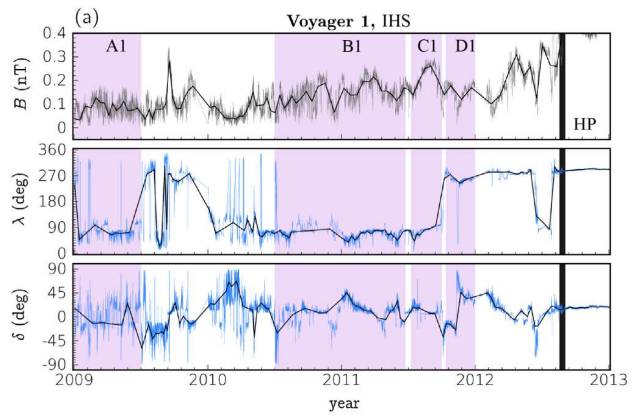 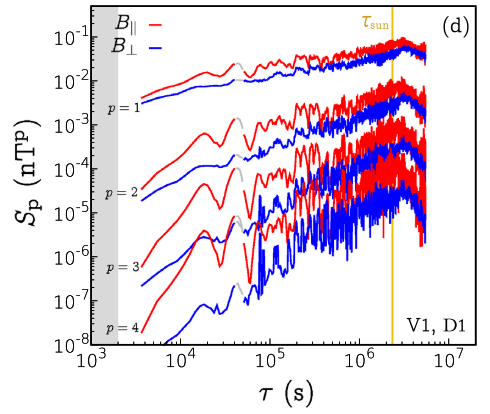

Slopes obtained over the highlighted ranges by authors, and their ESS theoretical values:

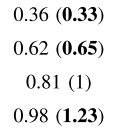


- Coincidentally, the slopes calcualted from our down-sampled data actually line up better with these theoretical values than their ones.
- A spectral break was not identified in the (corrected) spectra for this interval, but elsewhere it was found to be at about 1-2e-5
- We can see the periodicity of gaps in the sample size curve, with the vertical red lines indicating multiples of the dominant periodicity of 12 hours (there is a typically daily telemetry gap of 8-16 hours). The first line lines up with a major trough in $N(\tau)$): **subsequent multiples line up with local minima AND maxima - should investigate further** 


#### Issues with comparing results

##### Complete SFs

- We are simplifying by down-sampling for ease of time, and approximating B_parallel with B_T

##### Corrected SFs
- We are computing vector SFs. Not only is not the same as them, but it also complicates the picture of re-scaling back to the original units. Chen (2012) work with normalised SFs may possibly help here.
- Not yet shown here, but below we perform our de-biasing of an interpolated version of this interval (shown by purple SFs). However, the correction factor is trained on 10 correlation lengths worth of data, with the SF calculated up to 2 $\lambda_C$, which, as shown by the vertical blue lines above, is much shorter than their intervals. 

## Computing standardised SFs

i.e. from intervals of 10,000 points across 10 correlation lengths, calculated up to lag 2,000.
Integral corr length `tc` has already been defined above.

In [33]:
tc_n = 10
interval_length = params.int_length
new_cadence = tc_n * tc / interval_length

lags = np.arange(1, params.max_lag_prop * params.int_length)
powers = [2]
file_index = 0
int_index = 0
version = 0

In [34]:
int_std_full = subset.resample(str(np.round(new_cadence, 3)) + "S").mean()
int_std = int_std_full[:10000]

C:\Users\spann\AppData\Local\Temp\ipykernel_15732\675709484.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  int_std_full = subset.resample(str(np.round(new_cadence, 3)) + "S").mean()


In [35]:
len(int_std_full)

121903

In [36]:
del subset

In [37]:
int_norm = utils.normalize(int_std)
bad_input = int_norm[["BR", "BT", "BN"]]

In [38]:
print(bad_input.isna().sum() / len(bad_input["BR"]))
missing = bad_input["BR"].isna().sum() / len(bad_input["BR"])

BR    0.6456
BT    0.6456
BN    0.6456
dtype: float64


In [39]:
bad_output = sf.compute_sf(bad_input, lags, powers, False, False)
bad_output["gap_handling"] = "naive"
bad_output["file_index"] = file_index
bad_output["int_index"] = int_index
bad_output["version"] = version

In [40]:
interp_input = (
    bad_input.interpolate(method="linear").ffill().bfill()
)  # Linearly interpolate (and, in case of missing values at edges, back and forward fill)
interp_output = sf.compute_sf(interp_input, lags, powers, False, False)

In [41]:
bad_input.std()

BR    1.0
BT    1.0
BN    1.0
dtype: float64

In [42]:
interp_input_df = pd.DataFrame(interp_input)
interp_input_df.reset_index(inplace=True)  # Make time a column, not an index

interp_output["file_index"] = 0
interp_output["int_index"] = 0
interp_output["version"] = 0
interp_output["gap_handling"] = "lint"

# Correcting sample size and uncertainty for linear interpolation, same values as no handling
interp_output["n"] = bad_output["n"]
interp_output["missing_percent"] = bad_output["missing_percent"]
interp_output["sf_2_se"] = bad_output["sf_2_se"]

In [43]:
n_bins = 25
output_path = "final"

sfs_gapped = pd.concat([interp_output, bad_output])

### Correcting SF

In [ ]:
output_path = "final"

In [46]:
# Importing lookup table
n_bins = 25
with open(
    f"data/corrections/{output_path}/correction_lookup_2d_{n_bins}_bins.pkl", "rb"
) as f:
    correction_lookup_2d = pickle.load(f)
with open(
    f"data/corrections/{output_path}/correction_lookup_3d_{n_bins}_bins.pkl", "rb"
) as f:
    correction_lookup_3d = pickle.load(f)

#### Smooth

Compute scaling, intervals outside of step 4a? Would make this a bit tidier.

In [47]:
import numpy as np
from scipy.ndimage import gaussian_filter


def smooth_with_missing_values(image, sigma):
    # 1. Create a mask of NaNs (True where NaNs are)
    nan_mask = np.isnan(image)

    # 2. Replace NaNs with a temporary value (e.g., the mean of the non-NaN values)
    image_filled = np.where(nan_mask, np.nanmean(image), image)

    # 3. Apply Gaussian filter to the filled image
    smoothed_image = gaussian_filter(image_filled, sigma=sigma)

    # 4. Create a binary mask where NaNs were, and apply the same filter
    mask = np.ones_like(image)
    mask[nan_mask] = 0
    smoothed_mask = gaussian_filter(mask, sigma=sigma)

    # 5. Combine the smoothed image with the smoothed mask
    result = smoothed_image / smoothed_mask

    # Optionally, restore NaNs to their original positions
    result[nan_mask] = np.nan

    return result

In [48]:
# correction_lookup_3d["pe_mean"] consists of 25x25x25 images. I want them each smoothed using smooth_with_missing_values()

correction_lookup_3d_blurred = correction_lookup_3d.copy()
correction_lookup_3d_blurred["pe_mean"] = np.empty_like(correction_lookup_3d["pe_mean"])

correction_lookup_3d_blurred["pe_mean"] = smooth_with_missing_values(
    correction_lookup_3d["pe_mean"], 3
)

correction_lookup_3d_blurred["scaling"] = 1 / (
    1 + correction_lookup_3d_blurred["pe_mean"] / 100
)

correction_lookup_3d_blurred["scaling_lower"] = 1 / (
    1
    + (
        correction_lookup_3d_blurred["pe_mean"]
        + 1 * correction_lookup_3d_blurred["pe_std"]
    )
    / 100
)

correction_lookup_3d_blurred["scaling_upper"] = 1 / (
    1
    + (
        correction_lookup_3d_blurred["pe_mean"]
        - 1 * correction_lookup_3d_blurred["pe_std"]
    )
    / 100
)

# Error checking in case of std overpowering mean and leading to PEs < -100% and therefore negative scalings
# By replacing with pe_min, which is more negative for underestimation, we can ensure scaling regions are not negative
# and therefore do not invert the structure function

replacement_scaling = 1 / (1 + (correction_lookup_3d_blurred["pe_min"]) / 100)

correction_lookup_3d_blurred["scaling_upper"][
    correction_lookup_3d_blurred["scaling_upper"] < 0
] = replacement_scaling[correction_lookup_3d_blurred["scaling_upper"] < 0]

Investigating odd scaling at lag of 1, affecting LISM correction. **Need to add error handling for this scaling calc: if scaling is < 0, replace pe_mean in scaling_calc with pe_min (will be more negative number for underestimation, so more intense correction)**

### Seems like we need to do this for both upper and lower scalings. But why should this ever happen for the lower scalings, when we are making the percent more positive, rather than more negative? Let's look at the scaling bounds and the corresponding pe_means and pe_stds. Let's got this.


In [49]:
print(correction_lookup_3d_blurred["scaling_lower"][:2, :2, :2])
print(correction_lookup_3d_blurred["scaling"][:2, :2, :2])
print(correction_lookup_3d_blurred["scaling_upper"][:2, :2, :2])

[[[1.23789716 1.24126183]
  [1.23987307 1.23609929]]

 [[       nan        nan]
  [       nan        nan]]]
[[[1.26232364 1.25701102]
  [1.27719205 1.27166159]]

 [[       nan        nan]
  [       nan        nan]]]
[[[1.28773351 1.27316501]
  [1.31682728 1.30933073]]

 [[       nan        nan]
  [       nan        nan]]]


### Plot 

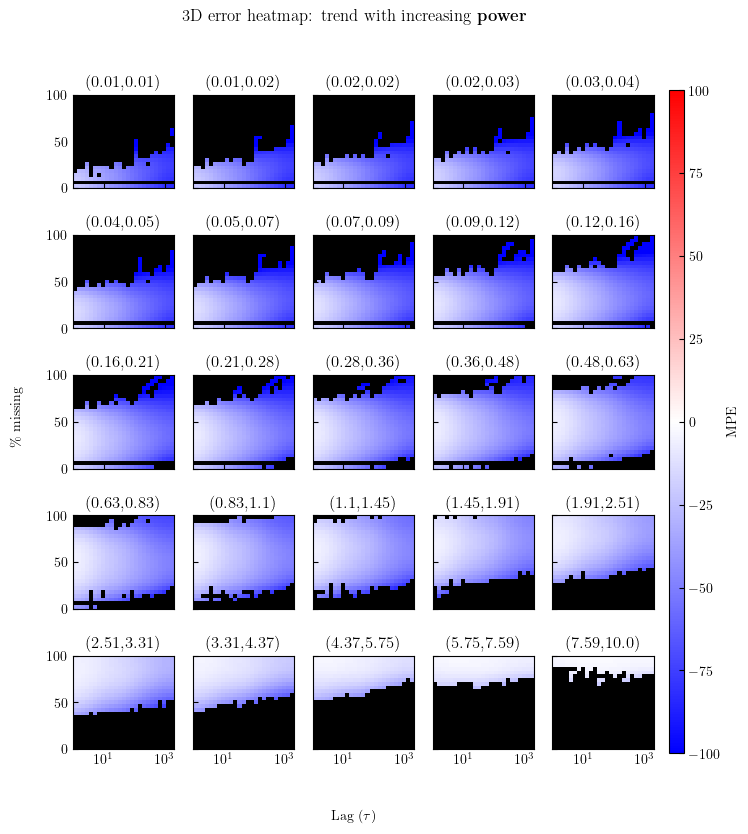

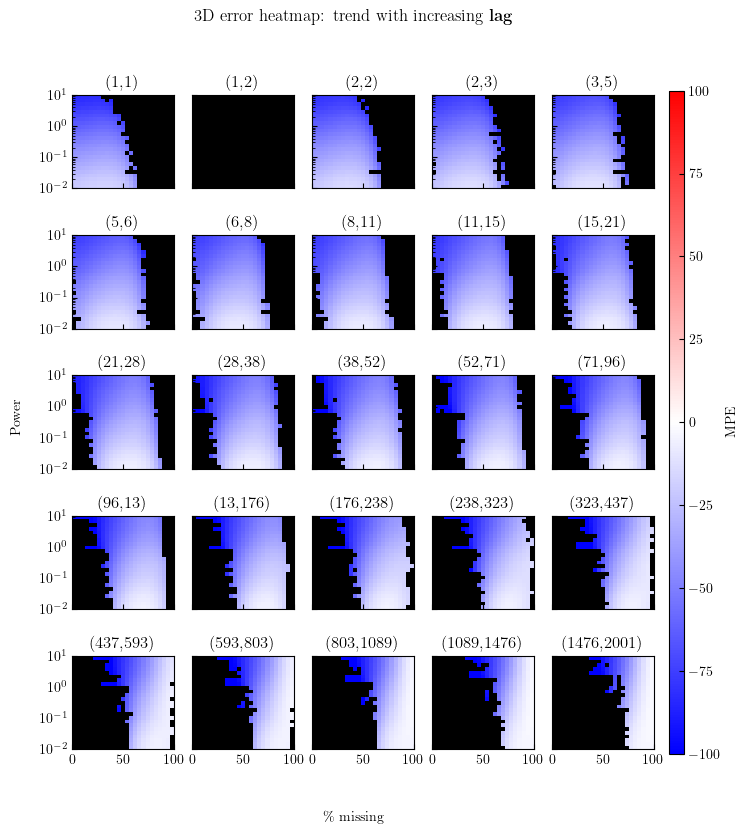

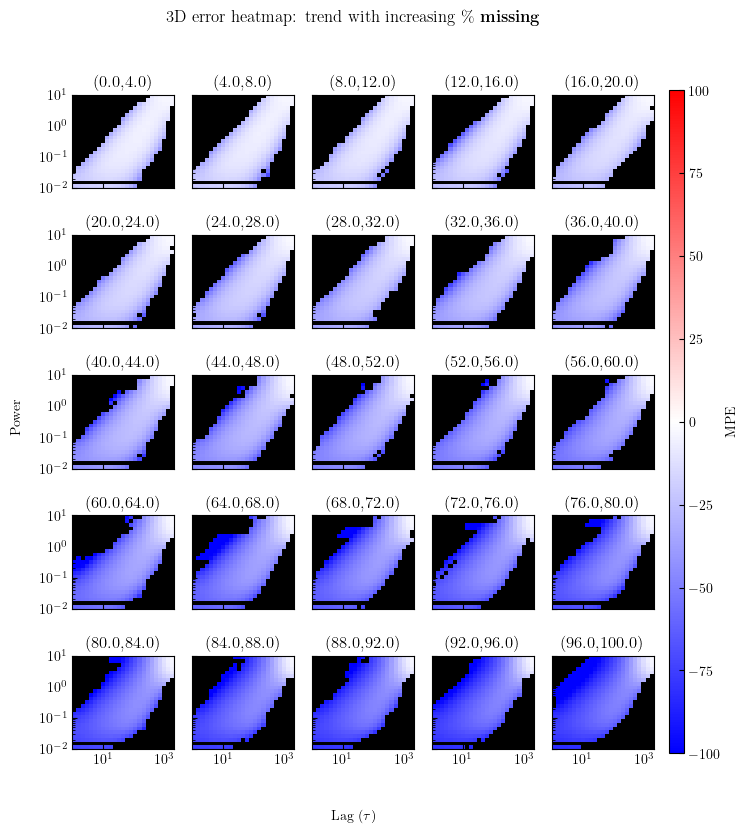

In [50]:
xedges = correction_lookup_3d["xedges"]
yedges = correction_lookup_3d["yedges"]
zedges = correction_lookup_3d["zedges"]
pe_mean = correction_lookup_3d_blurred["pe_mean"]

# Define the number of columns (you can adjust this as desired)
n_cols = 5  # Number of columns per row
n_rows = (n_bins + n_cols - 1) // n_cols  # Calculate number of rows needed

# MISSING VS LAG, BY POWER BIN
fig, ax = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * 1.5, n_rows * 1.7),
    sharex=True,
    sharey=True,
)
plt.subplots_adjust(wspace=0.18, hspace=0.5)
plt.grid(False)
plt.suptitle(
    r"3D error heatmap: trend with increasing $\mathbf{power}$",
    y=0.98,
)

# Flatten the axis array to simplify indexing
ax = ax.flatten()

for i in range(n_bins):
    ax[i].grid(False)
    c = ax[i].pcolormesh(
        xedges,
        yedges,
        pe_mean[:, :, i],
        cmap="bwr",
    )
    c.set_clim(-100, 100)
    ax[i].set_title(
        f"({np.round(zedges[i], 2)},{np.round(zedges[i+1], 2)})",
    )
    ax[i].set_facecolor("black")
    ax[i].semilogx()

fig.text(
    0.5,
    0.03,
    "Lag ($\\tau$)",
    ha="center",
    va="center",
)  # Shared x-axis label
fig.text(
    0.05,
    0.5,
    "\% missing",
    ha="center",
    va="center",
    rotation="vertical",
)  # Shared y-axis label

# Hide any extra subplots if n_bins is not a multiple of n_cols
for j in range(n_bins, len(ax)):
    fig.delaxes(ax[j])

# Add a color bar on the right-hand side of the figure, stretching down the entire height
cbar_ax = fig.add_axes(
    [0.92, 0.105, 0.02, 0.78]
)  # [left, bottom, width, height] to cover full height
cb = plt.colorbar(c, cax=cbar_ax)  # Attach the color bar to the last heatmap
cb.set_label("MPE")  # Optional: Label the color bar

# plt.savefig(
#     f"plots/results/{output_path}/train_heatmap_{n_bins}bins_3d_lint_power.pdf",
#     bbox_inches="tight",
# )
# plt.close()

# POWER VS % MISSING, BY LAG BIN
fig, ax = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * 1.5, n_rows * 1.7),
    sharex=True,
    sharey=True,
)
plt.subplots_adjust(wspace=0.18, hspace=0.5)
plt.grid(False)
plt.suptitle(
    r"3D error heatmap: trend with increasing $\mathbf{lag}$",
    y=0.98,  # Was 1.02 for 2 rows
)

# Flatten the axis array to simplify indexing
ax = ax.flatten()

# Format lag bin edges to integers
formatted_xedges = [f"{x:.0f}".rstrip("0").rstrip(".") for x in xedges]

for i in range(n_bins):
    ax[i].grid(False)
    c = ax[i].pcolormesh(
        yedges,
        zedges,
        pe_mean[i, :, :],
        cmap="bwr",
    )
    c.set_clim(-100, 100)
    ax[i].set_title(
        f"({formatted_xedges[i]},{formatted_xedges[i+1]})",
    )
    ax[i].set_facecolor("black")
    ax[i].semilogy()

fig.text(
    0.5, 0.03, "\% missing", ha="center", va="center"
)  # Shared x-axis label, was 0.00 y-val for 2 rows
fig.text(
    0.05,
    0.5,
    "Power",
    ha="center",
    va="center",
    rotation="vertical",
)  # Shared y-axis label

# Hide any extra subplots if n_bins is not a multiple of n_cols
for j in range(n_bins, len(ax)):
    fig.delaxes(ax[j])

# Add a color bar on the right-hand side of the figure, stretching down the entire height
cbar_ax = fig.add_axes(
    [0.92, 0.105, 0.02, 0.78]
)  # [left, bottom, width, height] to cover full height
cb = plt.colorbar(c, cax=cbar_ax)  # Attach the color bar to the last heatmap
cb.set_label("MPE")  # Optional: Label the color bar

# plt.savefig(
#     f"plots/results/{output_path}/train_heatmap_{n_bins}bins_3d_lint_lag.pdf",
#     bbox_inches="tight",
# )
# plt.close()

# POWER VS LAG, BIN % MISSING BIN
fig, ax = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * 1.5, n_rows * 1.7),
    sharex=True,
    sharey=True,
)
plt.subplots_adjust(wspace=0.18, hspace=0.5)
plt.grid(False)
plt.suptitle(
    r"3D error heatmap: trend with increasing \% $\mathbf{missing}$",
    y=0.98,
)
# Flatten the axis array to simplify indexing
ax = ax.flatten()

for i in range(n_bins):
    ax[i].grid(False)
    c = ax[i].pcolormesh(
        xedges,
        zedges,
        pe_mean[:, i, :],
        cmap="bwr",
    )
    c.set_clim(-100, 100)
    ax[i].set_title(
        f"({np.round(yedges[i], 2)},{np.round(yedges[i+1], 2)})",
    )
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()

fig.text(0.5, 0.03, "Lag ($\\tau$)", ha="center", va="center")  # Shared x-axis label
fig.text(
    0.05,
    0.5,
    "Power",
    ha="center",
    va="center",
    rotation="vertical",
)  # Shared y-axis label

# Hide any extra subplots if n_bins is not a multiple of n_cols
for j in range(n_bins, len(ax)):
    fig.delaxes(ax[j])

# Add a color bar on the right-hand side of the figure, stretching down the entire height
cbar_ax = fig.add_axes(
    [0.92, 0.105, 0.02, 0.78]
)  # [left, bottom, width, height] to cover full height
cb = plt.colorbar(c, cax=cbar_ax)  # Attach the color bar to the last heatmap
cb.set_label("MPE")  # Optional: Label the color bar

# plt.savefig(
#     f"plots/results/{output_path}/train_heatmap_{n_bins}bins_3d_lint_missing.pdf",
#     bbox_inches="tight",
# )
# plt.close()

In [ ]:
# Apply 2D and 3D scaling to test set, report avg errors

sfs_lint_corrected_2d = sf.compute_scaling(sfs_gapped, 2, correction_lookup_2d, n_bins)

sfs_lint_corrected_2d_3d = sf.compute_scaling(
    sfs_lint_corrected_2d, 3, correction_lookup_3d_blurred, n_bins
)

# Rename smoothed columns so not over-ridden when creating non-smoothed versions below
sfs_lint_corrected_2d_3d = sfs_lint_corrected_2d_3d.rename(
    columns={
        "sf_2_corrected_3d": "sf_2_corrected_3d_smoothed",
        "sf_2_lower_corrected_3d": "sf_2_lower_corrected_3d_smoothed",
        "sf_2_upper_corrected_3d": "sf_2_upper_corrected_3d_smoothed",
    }
)

sfs_lint_corrected_2d_3d = sf.compute_scaling(
    sfs_lint_corrected_2d_3d, 3, correction_lookup_3d, n_bins
)


correction_wide = sfs_lint_corrected_2d_3d[
    [
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "sf_2_corrected_2d",
        "sf_2_corrected_3d",
        "sf_2_corrected_3d_smoothed",
    ]
]
correction_long = pd.wide_to_long(
    correction_wide,
    ["sf_2"],
    i=["file_index", "int_index", "version", "lag", "missing_percent"],
    j="gap_handling",
    sep="_",
    suffix=r"\w+",
)
correction_bounds_wide = sfs_lint_corrected_2d_3d[
    [
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "sf_2_lower_corrected_2d",
        "sf_2_lower_corrected_3d",
        "sf_2_upper_corrected_2d",
        "sf_2_upper_corrected_3d",
        "sf_2_lower_corrected_3d_smoothed",
        "sf_2_upper_corrected_3d_smoothed",
    ]
]

correction_bounds_long = pd.wide_to_long(
    correction_bounds_wide,
    ["sf_2_lower", "sf_2_upper"],
    i=["file_index", "int_index", "version", "lag", "missing_percent"],
    j="gap_handling",
    sep="_",
    suffix=r"\w+",
)

corrections_long = pd.merge(
    correction_long,
    correction_bounds_long,
    how="inner",
    on=[
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "gap_handling",
    ],
).reset_index()

# Adding the corrections, now as a form of "gap_handling", back to the gapped SF dataframe
sfs_gapped_corrected = pd.concat([sfs_gapped, corrections_long])

Loaded 2D lookup table with 25 bins
Loaded 3D lookup table with 25 bins
Loaded 3D lookup table with 25 bins


[]

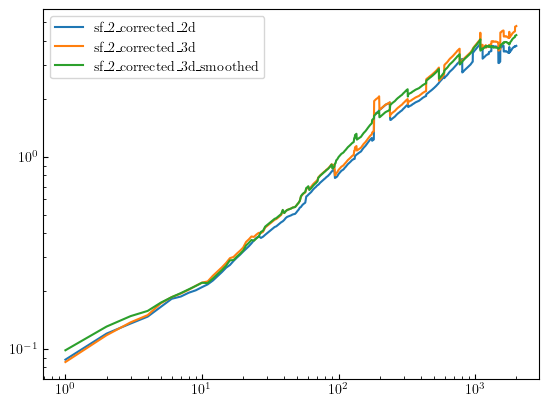

In [82]:
correction_wide[
    ["sf_2_corrected_2d", "sf_2_corrected_3d", "sf_2_corrected_3d_smoothed"]
].plot()
plt.semilogx()
plt.semilogy()

In [112]:
sf_corrected_raw = sfs_gapped_corrected.loc[
    (sfs_gapped_corrected["file_index"] == file_index)
    & (sfs_gapped_corrected["int_index"] == int_index)
    & (sfs_gapped_corrected["version"] == version)
    & (sfs_gapped_corrected["gap_handling"] == "corrected_3d_smoothed"),
    ["lag", "sf_2"],
]

## Plot of correction + equiv. spectrum

-1.4980296043933463


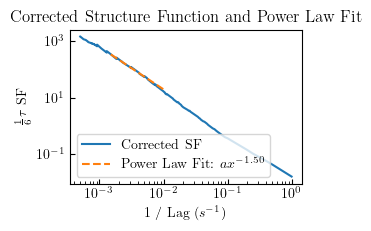

In [113]:
# Fit a power law to the corrected SF
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * x**b


sf_lags = sf_corrected_raw.lag.values
sf_corrected = sf_corrected_raw.sf_2.values
sf_corrected_es = sf_corrected * sf_lags / 6

popt, pcov = curve_fit(power_law, 1 / sf_lags[100:700], sf_corrected_es[100:700])

print(popt[1])

# Plotting the corrected structure function and the power law fit
plt.figure(figsize=(3, 2))
plt.loglog(1 / sf_lags, sf_corrected_es, label="Corrected SF")
plt.loglog(
    1 / sf_lags[100:700],
    power_law(1 / sf_lags[100:700], *popt),
    label=f"Power Law Fit: $a x^{{{popt[1]:.2f}}}$",
    linestyle="--",
)
plt.xlabel("1 / Lag ($s^{-1}$)")
plt.ylabel("$\\frac{1}{6} \\tau$ SF")
plt.title("Corrected Structure Function and Power Law Fit")
plt.legend()
plt.show()

Let's compare with the values for the uncorrected version (JUST LOOK AT SECOND VALUE OF FIRST ARRAY)

In [114]:
# sf_corrected_raw = sfs_gapped_corrected.loc[
#     (sfs_gapped_corrected["file_index"] == file_index)
#     & (sfs_gapped_corrected["int_index"] == int_index)
#     & (sfs_gapped_corrected["version"] == version)
#     & (sfs_gapped_corrected["gap_handling"] == "lint"),
#     ["lag", "sf_2"],
# ]

# sf_corrected = sf_corrected_raw.sf_2.values
# sf_corrected_es = sf_corrected * sf_lags / 6

# curve_fit(power_law, 1 / sf_lags[100:700], sf_corrected_es[100:700])

Low-effort attempt at getting equivalent vals from Frat spectrum, Fig. 5(d), using automeris:

![alt text](<Screenshot 2024-09-19 093332.png>)

Bit confused about which values to extract. Also, note that this power spectra was built using the technique they developed of compressed 
sensing, as well as linear interpolation + BT-method for $f<10^{-5}$


In [115]:
# Data extracted from above plot (blue line)
frat_ps_vals = [
    (1.9586685370794914e-7, 1214.0852101358987),
    (2.6175639572652317e-7, 709.7801854057238),
    (3.323132831812942e-7, 970.6814896628231),
    (3.8436683789616897e-7, 287.6712811003223),
    (5.326921437249581e-7, 466.75738702635005),
    (6.028118130649674e-7, 186.25711096568565),
    (7.516757029580683e-7, 114.45191198056837),
    (9.862129323881002e-7, 51.23513980249051),
    (0.0000014954605385256914, 32.618888142982826),
    (0.0000022221881417701954, 16.684580135675525),
    (0.000003251155681527389, 10.428368093916143),
    (0.000004478603920229663, 5.188479489025863),
    (0.000006180772295688527, 4.106210316944859),
    (0.000006554024787433551, 2.816006560381725),
    (0.000009106055036090965, 2.298879614928254),
    (0.000012066164622762502, 1.3829139565111448),
    (0.00001812791646144889, 1.2952051253088352),
    (0.000019068971762264177, 0.7986977367714028),
    (0.000028494129788973963, 0.5610559731858307),
    (0.00004002955586809482, 0.3418384307551636),
    (0.0000582863104666817, 0.1392278378008421),
    (0.00008269730024212859, 0.09081932250625169),
    (0.00008459622716742353, 0.05375830545339899),
    (0.000133759582011542, 0.039731210117758216),
    (0.00019876860604882952, 0.020465809192858002),
    (0.00027717053958634965, 0.01027033607089589),
    (0.000430782801051619, 0.005736452600402885),
    (0.000653475436819146, 0.003912156427837158),
    (0.0009911180510014863, 0.0025869154690401695),
    (0.0013751242031490312, 0.00513004265676919),
    (0.0015182381746486908, 0.0018458368116402695),
    (0.0022816771547936594, 0.001299704980747378),
    (0.0035032955431084684, 0.0009482966308469151),
    (0.005253700066695961, 0.0006755457757639566),
    (0.007973163150842257, 0.0004992122150458307),
    (0.010406710940112727, 0.0004848758696629409),
]

frat_ps_df = pd.DataFrame(frat_ps_vals, columns=["x", "y"])

Text(0, 0.5, '$\\frac{1}{6} \\tau$ SF')

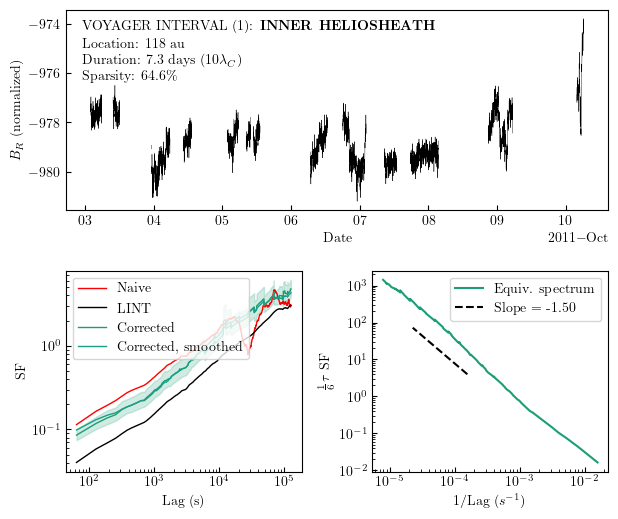

In [116]:
# fig, ax = plt.subplots(1, 3, figsize=(8, 2), constrained_layout=True)
fig = plt.figure(figsize=(7, 6))

gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
gs.update(hspace=0.3, wspace=0.3)  # Change 0.5 to control the spacing
# First row, spanning both columns
ax1 = fig.add_subplot(gs[0, :])

# Second row, first column
ax2 = fig.add_subplot(gs[1, 0])

# Second row, second column
ax3 = fig.add_subplot(gs[1, 1])


file_index = 0
int_index = 0
version = 0

ax1.plot(bad_input.index, bad_input["BR"], color="black", lw=0.3, label="Raw")
# ax1.plot(
#     interp_input_df["Time"],
#     interp_input_df["BR"],
#     color="black",
#     lw=1,
#     label="Linearly interpolated",
# )
ax1.set_xlabel("Date")
ax1.set_ylabel(r"$B_R$ (normalized)")
ax1.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator())
)
# ax1.set_title("Magnetic field @ 154 AU (Voyager 1, interstellar medium)"),
# ax1.set_title("Magnetic field @ 118 AU (Voyager 1, inner heliosheath)")

ax1.annotate(
    f"Location: 118 au\n \
    Duration: {np.round(tc*10/(24*60*60),1)} days ($10\\lambda_C$)\n \
    Sparsity: {float(missing*100):.1f}\%",
    xy=(1, 1),
    xycoords="axes fraction",
    xytext=(0.03, 0.65),  # 0.1 / 0.65
    textcoords="axes fraction",
    transform=ax1.transAxes,
    c="black",
    # bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round", alpha=0.7),
)

ax1.annotate(
    r"VOYAGER INTERVAL (1): \textbf{INNER HELIOSHEATH}",
    xy=(1, 1),
    xycoords="axes fraction",
    xytext=(0.03, 0.9),  # 0.03 / 0.28
    textcoords="axes fraction",
    transform=ax1.transAxes,
    c="black",
    # bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round", alpha=0.7),
)

ax2.set_xlabel("Lag (s)")
ax2.set_ylabel("SF")

ax2.plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "naive"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "naive"),
        "sf_2",
    ],
    color="red",
    lw=1,
    label="Naive",
)
ax2.plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "lint"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "lint"),
        "sf_2",
    ],
    color="black",
    lw=1,
    label="LINT",
)
ax2.plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2",
    ],
    color="#1b9e77",
    lw=1,
    label="Corrected",
)
ax2.plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d_smoothed"),
        "sf_2",
    ],
    color="#1b9e85",
    lw=1,
    label="Corrected, smoothed",
)
ax2.fill_between(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2_lower",
    ],
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2_upper",
    ],
    color="#1b9e77",
    alpha=0.2,
)
ax2.legend(loc="upper left")  # lower right
ax2.semilogx()
ax2.semilogy()

# Third panel (bottom right)
ax3.plot(
    1 / (sf_lags * new_cadence),
    sf_corrected_es,
    label="Equiv. spectrum",
    c="#1b9e77",
)
ax3.plot(
    1 / (sf_lags[100:700] * new_cadence),
    power_law(1 / sf_lags[100:700], *popt) / 5,
    label="Slope = {:.2f}".format(popt[1]),
    ls="--",
    color="black",
)
ax3.semilogx()
ax3.semilogy()
ax3.legend(loc="upper right")
ax3.set_xlabel("1/Lag ($s^{-1}$)")
ax3.set_ylabel(r"$\frac{1}{6} \tau$ SF")
# plt.savefig("plots/results/final/voyager_ihs.pdf")

In [117]:
sfs_gapped_corrected.loc[
    (sfs_gapped_corrected["file_index"] == file_index)
    & (sfs_gapped_corrected["int_index"] == int_index)
    & (sfs_gapped_corrected["version"] == version)
    & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
    ["sf_2", "sf_2_lower", "sf_2_upper"],
]

,sf_2,sf_2_lower,sf_2_upper
1.0,0.085407,0.074321,0.100382
4.0,0.117744,0.100936,0.141267
7.0,0.137444,0.115646,0.169368
10.0,0.149852,0.126838,0.183068
13.0,0.172691,0.143361,0.217109
...,...,...,...
5983.0,4.784723,3.918896,6.141633
5986.0,4.785829,3.919801,6.143053
5989.0,4.786980,3.920744,6.144531
5992.0,4.789254,3.922607,6.147450


---
## BELOW: Various attempts at post-correction smoothing, none satisfactory due to worse bumps at large lags not smoothed enough

### Moving average of SF

In [127]:
# Extracting corrected SF prior to smoothing attempt

curve = sfs_gapped_corrected.loc[
    (sfs_gapped_corrected["file_index"] == file_index)
    & (sfs_gapped_corrected["int_index"] == int_index)
    & (sfs_gapped_corrected["version"] == version)
    & (sfs_gapped_corrected["gap_handling"] == "corrected_3d_smoothed"),
    ["lag", "sf_2"],
]

In [128]:
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

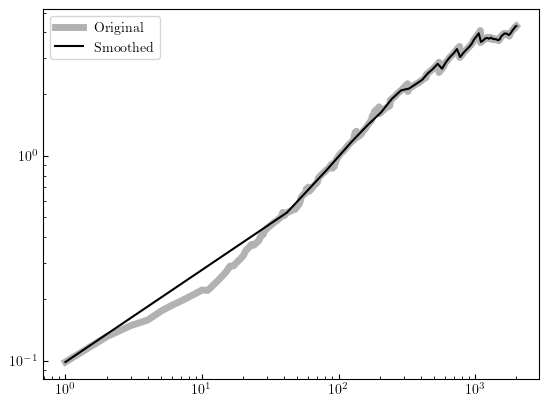

In [129]:
interp_model = interp1d(curve["lag"], curve["sf_2"], kind="cubic")

xnew = np.linspace(curve["lag"].min(), curve["lag"].max(), 50)
ysmooth = interp_model(xnew)
plt.plot(curve["lag"], curve["sf_2"], label="Original", color="black", alpha=0.3, lw=5)
plt.plot(xnew, ysmooth, label="Smoothed", color="black")
plt.semilogx()
plt.semilogy()
plt.legend()

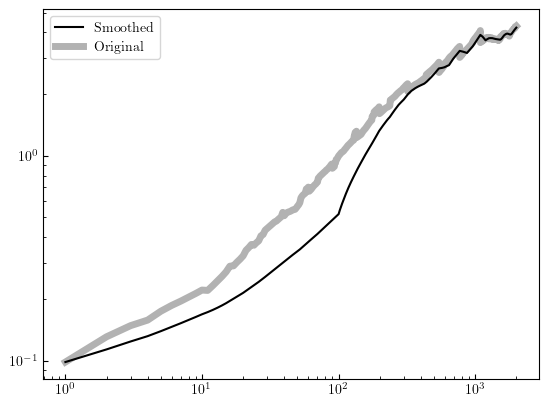

In [130]:
log_sf_2 = np.log(curve["sf_2"])
# log_sf_2_smoothed = log_sf_2.expanding().mean()
log_sf_2_smoothed = log_sf_2.rolling(min_periods=1, window=100).mean()
# log_sf_2_smoothed = savgol_filter(log_sf_2, 101, 3)
sf_2_smoothed = np.exp(log_sf_2_smoothed)
plt.plot(curve["lag"], sf_2_smoothed, label="Smoothed", color="black")
plt.plot(curve["lag"], curve["sf_2"], label="Original", color="black", alpha=0.3, lw=5)
plt.semilogx()
plt.semilogy()
plt.legend()

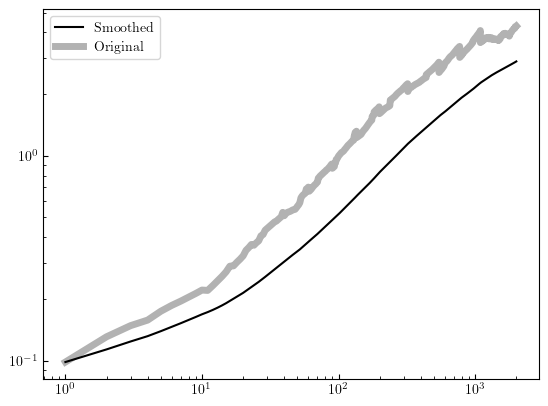

In [131]:
log_sf_2 = np.log(curve["sf_2"])
log_sf_2_smoothed = log_sf_2.expanding().mean()
# log_sf_2_smoothed = savgol_filter(log_sf_2, 101, 3)
sf_2_smoothed = np.exp(log_sf_2_smoothed)
plt.plot(curve["lag"], sf_2_smoothed, label="Smoothed", color="black")
plt.plot(curve["lag"], curve["sf_2"], label="Original", color="black", alpha=0.3, lw=5)
plt.semilogx()
plt.semilogy()
plt.legend()

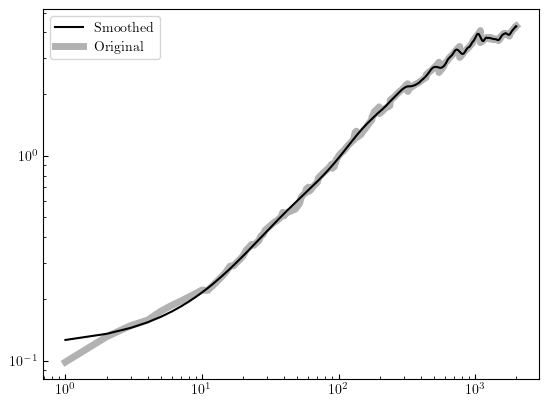

In [132]:
log_sf_2 = np.log(curve["sf_2"])
log_sf_2_smoothed = savgol_filter(log_sf_2, 300, 7)
sf_2_smoothed = np.exp(log_sf_2_smoothed)
plt.plot(curve["lag"], sf_2_smoothed, label="Smoothed", color="black")
plt.plot(curve["lag"], curve["sf_2"], label="Original", color="black", alpha=0.3, lw=5)
plt.semilogx()
plt.semilogy()
plt.legend()

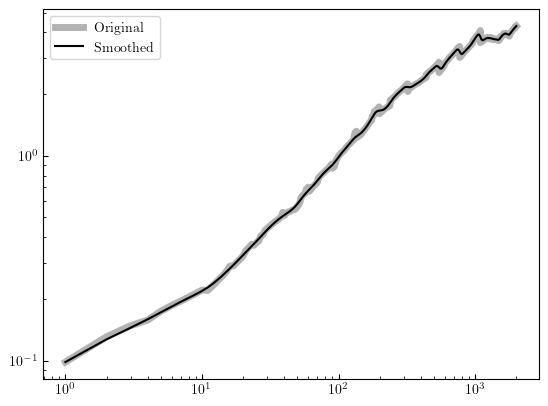

In [135]:
smoothed = SmoothySpec(curve["sf_2"].values)
plt.plot(curve["lag"], curve["sf_2"], label="Original", color="black", alpha=0.3, lw=5)
plt.plot(curve["lag"], smoothed, label="Smoothed", color="black")
plt.semilogx()
plt.semilogy()
plt.legend()